# 311 Neural Networks

### References:
- Convert to grayscale: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744
- Keras early stopping: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
- Grayscale Keras: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
- Combining models: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
- Neighborhoods geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Plotting in folium: https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db2



In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
import glob
from PIL import Image

# Import Components for model building
# Import various components for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the backend
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

% matplotlib inline

In [9]:
# Using the first 60000 data points
# Limited due to computational time and disc space
files = glob.glob('bw_pickles/bw_[0-9]*.gzde')
dim1, dim2, dim3 = 128, 128, 1

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

# Drop files without an image
df.dropna(subset=['image'], inplace=True)
df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['month'] = df['month'].astype('int16')
df['year'] = df['year'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['police_district'] = df['police_district'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['status'] = df['status'].astype('category')
df['responsible_agency'] = df['responsible_agency'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')

X_image = np.concatenate(df.image.values.tolist(), axis=0)
X_flat = X_image.reshape(df.shape[0], dim1*dim2*dim3)   

In [10]:
# The shape isn't quite right
X_image.shape

(8780800, 128)

In [11]:
X_image = X_image.reshape(df.shape[0], dim1, dim2, dim3)
X_image.shape

(68600, 128, 128, 1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68600 entries, 19000 to 41999
Data columns (total 23 columns):
caseid                 68600 non-null int64
opened                 68600 non-null datetime64[ns]
closed                 67292 non-null datetime64[ns]
updated                68600 non-null datetime64[ns]
status                 68600 non-null category
status_notes           44331 non-null object
responsible_agency     68600 non-null category
category               68600 non-null category
request_type           68600 non-null object
request_details        67303 non-null object
address                68600 non-null object
street                 68600 non-null object
supervisor_district    68596 non-null float64
neighborhood           68600 non-null object
police_district        68438 non-null category
latitude               68600 non-null float64
longitude              68600 non-null float64
point                  68600 non-null object
source                 68600 non-null objec

In [13]:
df.head(2)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month,image
19000,8543771,2018-01-23 16:24:30,2018-09-14 11:01:02,2018-09-14 11:01:02,Closed,Sign repaired or replaced. Please resubmit if ...,DPT SignShop 07 Queue,Sign Repair,Sign - Defaced,Other_Parking_Type - Defaced; support - OK,...,Ingleside Terraces,TARAVAL,37.725200,-122.464140,"(37.72519955, -122.46413986)",Mobile/Open311,http://mobile311.sfgov.org/reports/8543771/photos,2018,1,"[[247, 248, 247, 248, 247, 247, 248, 247, 246,..."
19001,7374852,2017-07-14 14:13:06,2017-07-15 22:40:22,2017-07-15 22:40:22,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,Liquids - Oil/Paint/Other,...,Mission,MISSION,37.752708,-122.411804,"(37.75270844, -122.4118042)",Mobile/Open311,http://mobile311.sfgov.org/reports/7374852/photos,2017,7,"[[8, 9, 9, 7, 11, 9, 73, 77, 75, 74, 75, 74, 7..."


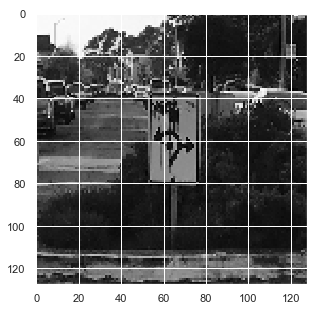

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(X_image[0].reshape(128, 128), cmap='gray')
plt.show()

In [32]:
X_image[0].shape

(128, 128, 1)

In [16]:
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [17]:
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Signs - Illegal Postings and Repair' 'Hazardous Materials'
 'General Cleaning' 'Human or Medical Waste' 'Encampments' 'Graffiti'
 'Litter Receptacles' 'Vehicle' 'Sewer Issues'
 'Street and Sidewalk Issues' 'Bulky Items' 'Other'
 'Rec and Park Requests' 'Tree Maintenance' 'Damaged Property'
 'Streetlights']
16


In [18]:
df.category.unique()

[Sign Repair, Street and Sidewalk Cleaning, Encampments, Graffiti, Litter Receptacles, ..., General Request - ENTERTAINMENT COMMISSION, General Request - RPD, General Request - PORT AUTHORITY, General Request - ANIMAL CARE CONTROL, General Request - CENTRAL SHOPS]
Length: 29
Categories (29, object): [Sign Repair, Street and Sidewalk Cleaning, Encampments, Graffiti, ..., General Request - RPD, General Request - PORT AUTHORITY, General Request - ANIMAL CARE CONTROL, General Request - CENTRAL SHOPS]

In [19]:
print(df['category'].unique())
print(df['category'].nunique())

[Sign Repair, Street and Sidewalk Cleaning, Encampments, Graffiti, Litter Receptacles, ..., General Request - ENTERTAINMENT COMMISSION, General Request - RPD, General Request - PORT AUTHORITY, General Request - ANIMAL CARE CONTROL, General Request - CENTRAL SHOPS]
Length: 29
Categories (29, object): [Sign Repair, Street and Sidewalk Cleaning, Encampments, Graffiti, ..., General Request - RPD, General Request - PORT AUTHORITY, General Request - ANIMAL CARE CONTROL, General Request - CENTRAL SHOPS]
29


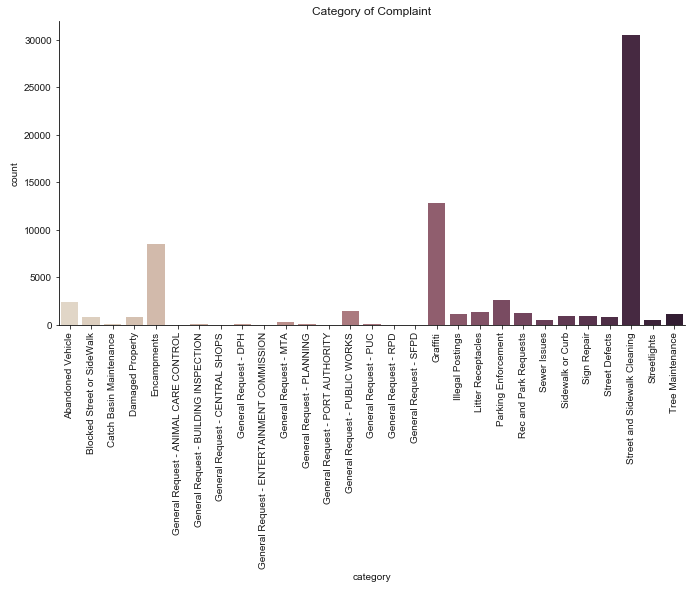

In [20]:
sns.catplot(x='category', 
            kind='count', 
            palette="ch:.25", 
            height=5, 
            aspect=2, 
            data=df)
sns.set(rc={'figure.figsize':(10,20)})
plt.xticks(rotation=90)
plt.title('Category of Complaint')
plt.show()

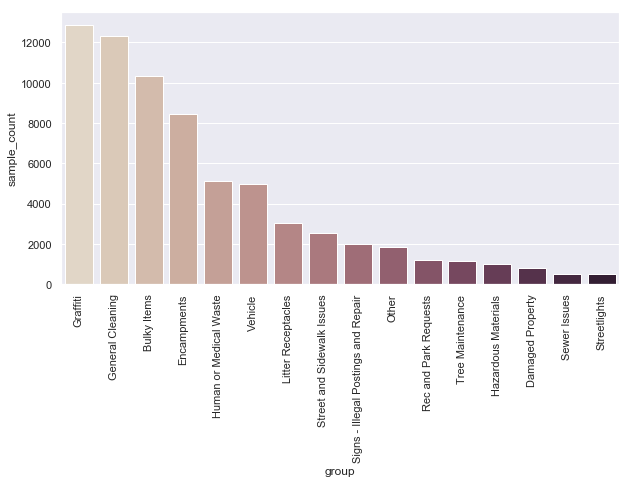

In [34]:
requested = df.groupby('group').count()['caseid'].sort_values(ascending=False).reset_index()
requested.columns = ['group', 'sample_count']

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='group', 
            y='sample_count', 
            palette="ch:.25",
            ax=ax,
            data=requested)
plt.xticks(rotation=90)
plt.show()

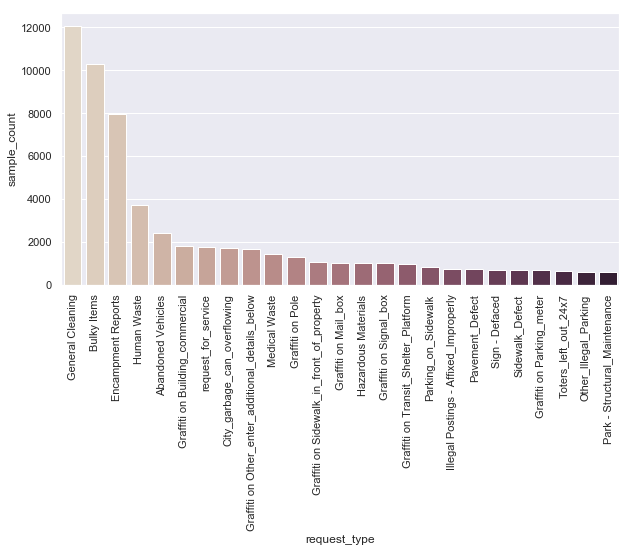

In [33]:
requested = df.groupby('request_type').count()['caseid'].sort_values(ascending=False)[0:25].reset_index()
requested.columns = ['request_type', 'sample_count']
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='request_type', 
                 y='sample_count', 
                 palette="ch:.25", 
                 data=requested)
plt.xticks(rotation=90)
plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, 
                                                    df['group'], 
                                                    test_size=0.25,
                                                    random_state=42)

In [43]:
X_image.shape

(68600, 128, 128, 1)

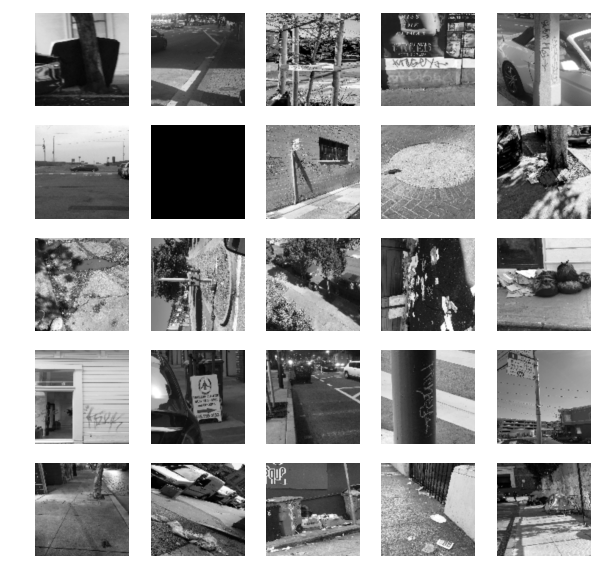

In [44]:
#Examples of dataset
#X_train_image = X.reshape(X.shape[0], 128, 128, 3)

#Visualizing dataset
#fig, axes1 = plt.subplots(5,5,figsize=(10,10))
#for j in range(5):
#    for k in range(5):
#        i = np.random.choice(range(len(X_train_image)))
#        axes1[j][k].set_axis_off()
#        axes1[j][k].imshow(X_train_image[i:i+1][0], 
#                           interpolation='gaussian')
        
        
#Visualizing dataset
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_image)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_image[i:i+1][0].reshape(128, 128),
                           cmap='gray',
                           interpolation='gaussian')        

# Multi-Layer Perceptron


In [37]:
# Convert to float32 for type consistency
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train /= 255
X_test /= 255

# Print sample sizes
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
# instead of one column with 10 values, create 29 binary columns
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train = keras.utils.to_categorical(y_train_enc, 16)
y_test = keras.utils.to_categorical(y_test_enc, 16)

51450 train samples
17150 test samples


In [40]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the
# first layer
# Relu is the activation function
model.add(Dense(64, activation='relu', input_shape=(dim1*dim2,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have
model.add(Dense(16, activation='softmax'))

model.summary()


# Compile the model to put it all together
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(),
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_MLP.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1048640   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
Total params: 1,053,840
Trainable params: 1,053,840
Non-trainable params: 0
_________________________________________________________________
Train on 51450 samples, validate on 17150 samples
Epoch 1/20
51450/51450 [==============================] - 22s 421us/step - loss: 2

Not amazing considering half are street or sidewalk cleaning

# Convolutional Neural Network
- Black and White 128x128 images

In [55]:
le_group = LabelEncoder()
y_group = le_group.fit_transform(df['group'])

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_flat[0:5000], 
                                                            df['group'][0:5000], 
                                                            test_size=0.25,
                                                            random_state=42)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_g)
y_test_enc = le.transform(y_test_g)

y_train_g = keras.utils.to_categorical(y_train_enc, 16)
y_test_g = keras.utils.to_categorical(y_test_enc, 16)

# Convert to float32 for type consistency
X_train_g = X_train_g.astype('float32')
X_test_g = X_test_g.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train_g /= 255
X_test_g /= 255

img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 1)

X_train_g = X_train_g.reshape(X_train_g.shape[0], img_rows, img_cols, 1)
X_test_g = X_test_g.reshape(X_test_g.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
num_classes = 16

print('x_train shape:', X_train_g.shape)
print(X_train_g.shape[0], 'train samples')
print(X_test_g.shape[0], 'test samples')

x_train shape: (3750, 128, 128, 1)
3750 train samples
1250 test samples


In [58]:
y_test_g.shape

(1250, 16)

In [59]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(128, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit(X_train_g, y_train_g,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(X_test_g, y_test_g))
score = model.evaluate(X_test_g, y_test_g, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3750/3750 [==============================] - 1140s 304ms/step - loss: 2.7236 - acc: 0.1544 - val_loss: 2.4725 - val_acc: 0.1976
Epoch 2/10
3750/3750 [==============================] - 1189s 317ms/step - loss: 2.4749 - acc: 0.1760 - val_loss: 2.2973 - val_acc: 0.2208
Epoch 3/10
3750/3750 [==============================] - 1165s 311ms/step - loss: 2.4180 - acc: 0.1859 - val_loss: 2.3507 - val_acc: 0.1992
Epoch 4/10
3750/3750 [==============================] - 1122s 299ms/step - loss: 2.3667 - acc: 0.1992 - val_loss: 2.2851 - val_acc: 0.2392
Epoch 5/10
3750/3750 [==============================] - 1007s 269ms/step - loss: 2.3546 - acc: 0.1989 - val_loss: 2.2689 - val_acc: 0.2592
Epoch 6/10
3750/3750 [==============================] - 1043s 278ms/step - loss: 2.3143 - acc: 0.2259 - val_loss: 2.2635 - val_acc: 0.2448
Epoch 7/10
3750/3750 [==============================] - 1045s 279ms/step - loss: 2.2711 - acc: 0.2413 - val_loss: 2.29

In [60]:
y_pred = model.predict(X_test_g)  
#y_pred_labels = np.argmax(y_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

#confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)  

In [61]:
y_pred.shape

(1250, 16)

In [63]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_conf = np.argmax(y_test_g, axis=1)
confusion_matrix = confusion_matrix(y_true=y_test_conf, y_pred=y_pred_labels)  

In [64]:
print(confusion_matrix)

[[ 30   0   3   2 144   0   0   0   0   0   0   0   0   0   0   2]
 [  1   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0]
 [ 30   0   7   0 119   0   0   0   0   0   0   0   0   0   0   5]
 [ 33   0   9   3 177   0   0   0   0   0   0   0   0   0   0   5]
 [ 17   0   9   0 218   0   0   0   0   0   0   0   0   0   0   3]
 [  3   0   1   0  16   0   0   0   0   0   0   0   0   0   0   0]
 [  6   0   1   1  75   0   0   0   0   0   0   0   0   0   0   3]
 [ 13   0   1   1  47   0   0   0   0   0   0   0   0   0   0   1]
 [ 10   0   3   0  21   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   1   0  16   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   4   0  24   0   0   0   0   0   0   0   0   0   0   1]
 [  4   0   1   0  31   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   5   0   0   0   0   0   0   0   0   0   0   1]
 [  5   0   2   0  18   0   0   0   0   0   0   0   0   0   0 

In [ ]:
print(le_group.inverse_transform(range(0, 16)))
print(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))
print('classified as:')
print(le_group.inverse_transform([0, 2, 3, 4, 9, 12]))

No predictions for the following: 'Damaged Property' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Streetlights' 'Tree Maintenance'
 'Vehicle']

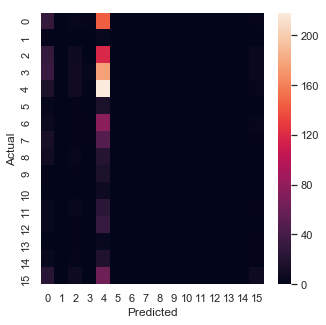

In [66]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
new_others = list(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))

In [ ]:
new_others

In [ ]:
df['group2'] = df['group']
df['group2'] = df['group2'].replace(to_replace=new_others, value='Other')
print(df['group2'].nunique())

In [ ]:
df.head()

# Model for Categorical Variables - Multi Layer Perceptron (MLP)

In [69]:
features = ['month', 'neighborhood', 'street']

In [97]:
# Select features and one hot encode
X_cat = df[features][0:5000].copy()
ohe = OneHotEncoder()
X_cat = ohe.fit_transform(X_cat)
print('Shapes: \n')
print('X one hot encoded: {}'.format(X_cat.shape))

# Use same y as before, same random_state
X_cat_train, X_cat_test = train_test_split(X_cat, 
                                           test_size=0.25,
                                           random_state=42)

# Select features with variance threshold of 99.95%
# 1 or 0 in more than 99.95% of samples
sel = VarianceThreshold(threshold=(.9995*(1-.9995)))
X_sel_train = sel.fit_transform(X_cat_train)
X_sel_test = sel.transform(X_cat_test)
print('X_train Variance Threshold: {}'.format(X_sel_train.shape))

# Select K Best Features
k_num = X_sel_train.shape[1]
sel_k = SelectKBest(chi2, k=k_num)
X_sel_k = sel_k.fit_transform(X_sel_train, y_train_g)
X_sel_k_test = sel_k.transform(X_sel_test)
print('X_train Select K Best, K={}: {}'.format(k_num, X_sel_k.shape))

Shapes: 

X one hot encoded: (5000, 903)
X_train Variance Threshold: (3750, 540)
X_train Select K Best, K=540: (3750, 540)


In [98]:
input_shape = X_sel_k.shape[1]

model_mlp = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the
# first layer
# Relu is the activation function
model_mlp.add(Dense(64, activation='relu', input_shape=(input_shape,)))
# Dropout layers remove features and fight overfitting
model_mlp.add(Dropout(0.1))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have
model_mlp.add(Dense(16, activation='softmax'))

model_mlp.summary()


# Compile the model to put it all together
model_mlp.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_cat.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model_mlp.fit(X_sel_k, y_train_g,
                        batch_size=128,
                        epochs=20,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_sel_k_test, y_test_g))
score = model_mlp.evaluate(X_sel_k_test, y_test_g, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 64)                34624     
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 16)                1040      
Total params: 39,824
Trainable params: 39,824
Non-trainable params: 0
_________________________________________________________________
Train on 3750 samples, validate on 1250 samples
Epoch 1/20
3750/3750 [==============================] - 1s 215us/step - loss: 2.6067 - acc

In [104]:
# combine the output of previous two models
combined_input = Concatenate([model_mlp.output, model.output])

AttributeError: 'Concatenate' object has no attribute 'shape'

# Combine Models

In [107]:
# Start with a simple sequential model
model_combo = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the
# first layer
# Relu is the activation function
model_combo.add(Dense(4, activation='relu', input_shape=(16,)))
# Dropout layers remove features and fight overfitting
model_combo.add(Dropout(0.1))
model_combo.add(Dense(2, activation='relu'))
model_combo.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have
model_combo.add(Dense(16, activation='softmax'))

model_combo.summary()


# Compile the model to put it all together
model_combo.compile(loss='categorical_crossentropy', 
                    optimizer=RMSprop(),
                    metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_combined.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model_combo.fit(combined_input, y_train,
                          batch_size=128,
                          epochs=20,
                          verbose=1,
                          callbacks=callbacks)
#score = model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_39 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_40 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_56 (Dense)             (None, 16)                48        
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'Concatenate' object has no attribute 'ndim'